<a href="https://colab.research.google.com/github/Pennelli02/IAModels/blob/main/Copia_di_sample_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Florence-2-large sample usage

In [4]:
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image
import requests
import copy
import torch
%matplotlib inline

In [5]:
model_id = 'microsoft/Florence-2-large'
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True, torch_dtype='auto').eval().cuda()
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

configuration_florence2.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_florence2.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- modeling_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


pytorch_model.bin:   0%|          | 0.00/1.56G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

## define the prediction function

In [6]:
def run_example(task_prompt, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt").to('cuda', torch.float16)
    generated_ids = model.generate(
      input_ids=inputs["input_ids"].cuda(),
      pixel_values=inputs["pixel_values"].cuda(),
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height)
    )

    return parsed_answer

## init image

In [7]:
from google.colab import drive
drive.mount('/content/drive')
image = Image.open("/content/drive/MyDrive/Immagini test/testGenerated.png")


Mounted at /content/drive


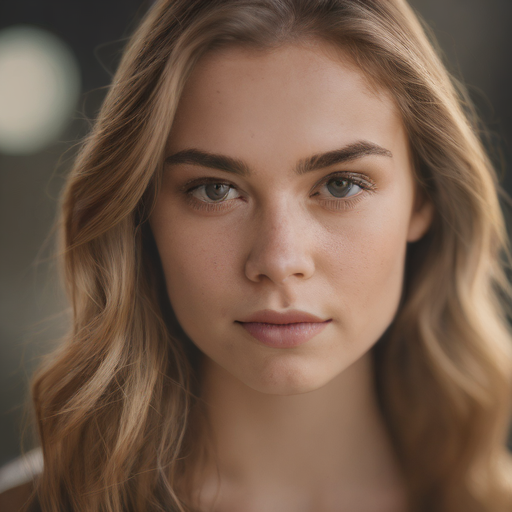

In [8]:
image

## Run pre-defined tasks without additional inputs

### Caption

In [9]:
task_prompt = '<CAPTION>'
run_example(task_prompt)

{'<CAPTION>': 'A woman with long blonde hair and blue eyes.'}

In [10]:
task_prompt = '<DETAILED_CAPTION>'
run_example(task_prompt)

{'<DETAILED_CAPTION>': 'The image shows a woman with long blonde hair and blue eyes in the foreground, while the background is blurred. She appears to be in the middle of a photoshoot, with her hair cascading down her shoulders and her eyes looking directly at the camera. Her expression is one of confidence and poise, as if she is ready to take on the world.'}

In [11]:
task_prompt = '<MORE_DETAILED_CAPTION>'
run_example(task_prompt)

{'<MORE_DETAILED_CAPTION>': "The image is a close-up portrait of a young woman's face. She has blonde hair that is styled in loose waves and falls over her shoulders. Her eyes are a piercing blue and her eyebrows are perfectly groomed. She is looking directly at the camera with a serious expression. The background is blurred, so the focus is on her face. The lighting is soft and natural, highlighting her features. The overall mood of the image is calm and serene."}

### Object detection

OD results format:
{'\<OD>':
    {
    'bboxes': [[x1, y1, x2, y2], ...],
    'labels': ['label1', 'label2', ...]
    }
}

In [12]:
task_prompt = '<OD>'
results = run_example(task_prompt)
print(results)

{'<OD>': {'bboxes': [[146.17601013183594, 41.72800064086914, 415.4880065917969, 395.52001953125], [1.7920000553131104, 1.28000009059906, 511.7440185546875, 510.72003173828125]], 'labels': ['human face', 'woman']}}


In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
def plot_bbox(image, data):
   # Create a figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Plot each bounding box
    for bbox, label in zip(data['bboxes'], data['labels']):
        # Unpack the bounding box coordinates
        x1, y1, x2, y2 = bbox
        # Create a Rectangle patch
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        # Add the rectangle to the Axes
        ax.add_patch(rect)
        # Annotate the label
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

    # Remove the axis ticks and labels
    ax.axis('off')

    # Show the plot
    plt.show()

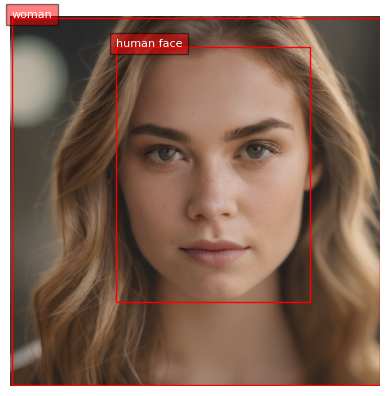

In [14]:
plot_bbox(image, results['<OD>'])

### Dense region caption

Dense region caption results format:
{'\<DENSE_REGION_CAPTION>': {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['label1', 'label2', ...]}}

In [15]:
task_prompt = '<DENSE_REGION_CAPTION>'
results = run_example(task_prompt)
print(results)

{'<DENSE_REGION_CAPTION>': {'bboxes': [[1.7920000553131104, 1.28000009059906, 511.7440185546875, 510.72003173828125], [146.17601013183594, 41.72800064086914, 415.4880065917969, 395.52001953125]], 'labels': ['young woman with blonde hair and blue eyes portrait', 'human face']}}


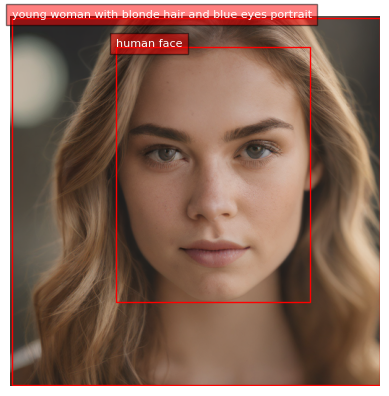

In [16]:
plot_bbox(image, results['<DENSE_REGION_CAPTION>'])

### Region proposal

Region proposal results format:
{'<REGION_PROPOSAL>' : {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['', '', ...]}}

In [17]:
task_prompt = '<REGION_PROPOSAL>'
results = run_example(task_prompt)
print(results)

{'<REGION_PROPOSAL>': {'bboxes': [[1.28000009059906, 1.28000009059906, 511.7440185546875, 510.72003173828125], [146.17601013183594, 41.72800064086914, 415.4880065917969, 395.52001953125], [243.4560089111328, 195.3280029296875, 316.1600036621094, 284.416015625], [232.1920166015625, 307.968017578125, 334.08001708984375, 348.9280090332031], [305.9200134277344, 168.70401000976562, 381.18402099609375, 209.6640167236328], [174.84800720214844, 174.3360137939453, 250.62400817871094, 213.24801635742188], [406.7840270996094, 184.0640106201172, 435.4560241699219, 241.92001342773438]], 'labels': ['', '', '', '', '', '', '']}}


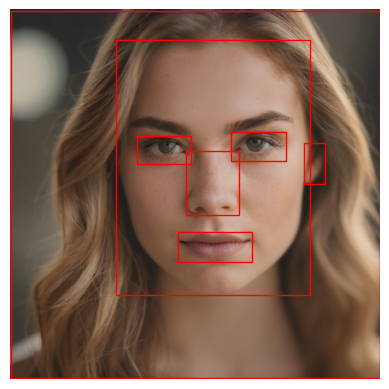

In [18]:
plot_bbox(image, results['<REGION_PROPOSAL>'])

## Run pre-defined tasks that requires additional inputs

### Phrase Grounding
Phrase grounding results format:
{'\<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['', '', ...]}}

In [19]:
task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
results = run_example(task_prompt, text_input="A portrait of young woman with brown eyes and yellow hair")
print(results)

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[24.32000160217285, 1.7920000553131104, 510.72003173828125, 510.72003173828125], [179.4560089111328, 168.70401000976562, 380.6720275878906, 211.71200561523438], [308.4800109863281, 169.72801208496094, 379.64801025390625, 205.56800842285156], [181.50401306152344, 176.38400268554688, 250.62400817871094, 210.68800354003906], [26.36800193786621, 1.7920000553131104, 510.72003173828125, 511.2320251464844]], 'labels': ['A portrait of young woman', 'brown eyes', 'brown eyes', 'brown eyes', 'yellow hair']}}


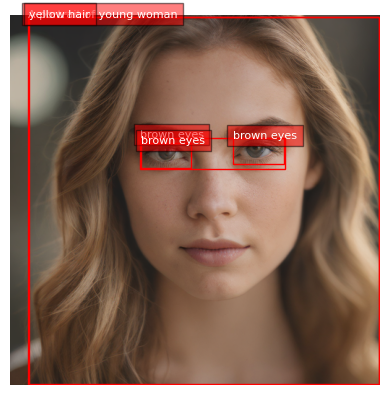

In [20]:
plot_bbox(image, results['<CAPTION_TO_PHRASE_GROUNDING>'])

### Referring expression segmentation

Referring expression segmentation results format:
{'\<REFERRING_EXPRESSION_SEGMENTATION>': {'Polygons': [[[polygon]], ...], 'labels': ['', '', ...]}}, one object is represented by a list of polygons. each polygon is [x1, y1, x2, y2, ..., xn, yn]

In [21]:
task_prompt = '<REFERRING_EXPRESSION_SEGMENTATION>'
results = run_example(task_prompt, text_input="a young woman")
print(results)

{'<REFERRING_EXPRESSION_SEGMENTATION>': {'polygons': [[[123.64800262451172, 56.064002990722656, 125.69600677490234, 52.99200439453125, 125.69600677490234, 50.94400405883789, 127.74400329589844, 47.87200164794922, 127.74400329589844, 45.82400131225586, 128.76800537109375, 43.7760009765625, 130.81600952148438, 41.72800064086914, 132.864013671875, 37.12000274658203, 134.91200256347656, 34.04800033569336, 136.9600067138672, 30.976001739501953, 139.0080108642578, 27.904001235961914, 141.05599975585938, 25.856000900268555, 142.0800018310547, 22.784000396728516, 144.1280059814453, 19.71200180053711, 146.17601013183594, 16.64000129699707, 148.22401428222656, 13.568000793457031, 149.760009765625, 10.496000289916992, 151.80801391601562, 7.424000263214111, 153.8560028076172, 4.3520002365112305, 155.9040069580078, 1.28000009059906, 157.95201110839844, 0.25600001215934753, 405.760009765625, 0.25600001215934753, 406.7840270996094, 2.30400013923645, 408.83203125, 5.37600040435791, 410.8800048828125, 

In [22]:
from PIL import Image, ImageDraw, ImageFont
import random
import numpy as np
colormap = ['blue','orange','green','purple','brown','pink','gray','olive','cyan','red',
            'lime','indigo','violet','aqua','magenta','coral','gold','tan','skyblue']
def draw_polygons(image, prediction, fill_mask=False):
    """
    Draws segmentation masks with polygons on an image.

    Parameters:
    - image_path: Path to the image file.
    - prediction: Dictionary containing 'polygons' and 'labels' keys.
                  'polygons' is a list of lists, each containing vertices of a polygon.
                  'labels' is a list of labels corresponding to each polygon.
    - fill_mask: Boolean indicating whether to fill the polygons with color.
    """
    # Load the image

    draw = ImageDraw.Draw(image)


    # Set up scale factor if needed (use 1 if not scaling)
    scale = 1

    # Iterate over polygons and labels
    for polygons, label in zip(prediction['polygons'], prediction['labels']):
        color = random.choice(colormap)
        fill_color = random.choice(colormap) if fill_mask else None

        for _polygon in polygons:
            _polygon = np.array(_polygon).reshape(-1, 2)
            if len(_polygon) < 3:
                print('Invalid polygon:', _polygon)
                continue

            _polygon = (_polygon * scale).reshape(-1).tolist()

            # Draw the polygon
            if fill_mask:
                draw.polygon(_polygon, outline=color, fill=fill_color)
            else:
                draw.polygon(_polygon, outline=color)

            # Draw the label text
            draw.text((_polygon[0] + 8, _polygon[1] + 2), label, fill=color)

    # Save or display the image
    #image.show()  # Display the image
    display(image)

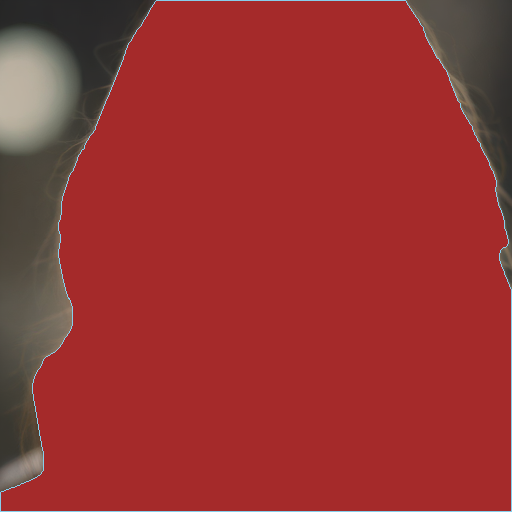

In [23]:
output_image = copy.deepcopy(image)
draw_polygons(output_image, results['<REFERRING_EXPRESSION_SEGMENTATION>'], fill_mask=True)

### region to segmentation


with additional region as inputs, format is '\<loc_x1>\<loc_y1>\<loc_x2>\<loc_y2>', [x1, y1, x2, y2] is the quantized corrdinates in [0, 999].

In [24]:
task_prompt = '<REGION_TO_SEGMENTATION>'
results = run_example(task_prompt, text_input="<loc_702><loc_575><loc_866><loc_772>")
print(results)

{'<REGION_TO_SEGMENTATION>': {'polygons': [[[355.5840148925781, 292.09600830078125, 445.6960144042969, 292.09600830078125, 445.6960144042969, 399.10400390625, 355.5840148925781, 399.10400390625]]], 'labels': ['']}}


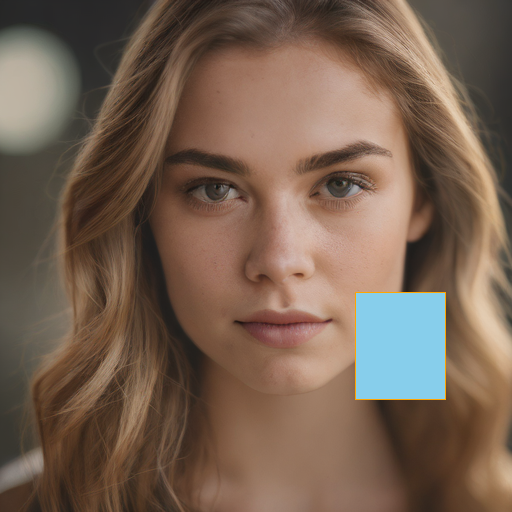

In [25]:
output_image = copy.deepcopy(image)
draw_polygons(output_image, results['<REGION_TO_SEGMENTATION>'], fill_mask=True)

### Open vocabulary detection

open vocabulary detection can detect both objects and ocr texts.

results format:

{ '\<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[x1, y1, x2, y2], [x1, y1, x2, y2], ...]], 'bboxes_labels': ['label_1', 'label_2', ..],
'polygons': [[[x1, y1, x2, y2, ..., xn, yn], [x1, y1, ..., xn, yn]], ...], 'polygons_labels': ['label_1', 'label_2', ...]
}}

In [26]:
task_prompt = '<OPEN_VOCABULARY_DETECTION>'
results = run_example(task_prompt, text_input="a brown eyes")
print(results)

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[178.4320068359375, 168.19200134277344, 380.6720275878906, 212.7360076904297], [307.968017578125, 169.21600341796875, 379.64801025390625, 206.08001708984375], [180.99200439453125, 175.36001586914062, 250.62400817871094, 211.71200561523438]], 'bboxes_labels': ['a brown eyes', 'a browneyes', 'a brown eye'], 'polygons': [], 'polygons_labels': []}}


In [27]:
def convert_to_od_format(data):
    """
    Converts a dictionary with 'bboxes' and 'bboxes_labels' into a dictionary with separate 'bboxes' and 'labels' keys.

    Parameters:
    - data: The input dictionary with 'bboxes', 'bboxes_labels', 'polygons', and 'polygons_labels' keys.

    Returns:
    - A dictionary with 'bboxes' and 'labels' keys formatted for object detection results.
    """
    # Extract bounding boxes and labels
    bboxes = data.get('bboxes', [])
    labels = data.get('bboxes_labels', [])

    # Construct the output format
    od_results = {
        'bboxes': bboxes,
        'labels': labels
    }

    return od_results

In [28]:
bbox_results  = convert_to_od_format(results['<OPEN_VOCABULARY_DETECTION>'])

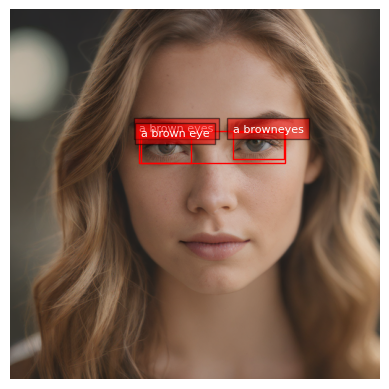

In [29]:
plot_bbox(image, bbox_results)

### region to texts

In [30]:
task_prompt = '<REGION_TO_CATEGORY>'
results = run_example(task_prompt, text_input="<loc_52><loc_332><loc_932><loc_774>")
print(results)

{'<REGION_TO_CATEGORY>': 'human head<loc_52><loc_332><loc_932><loc_774>'}


In [31]:
task_prompt = '<REGION_TO_DESCRIPTION>'
results = run_example(task_prompt, text_input="<loc_52><loc_332><loc_932><loc_774>")
print(results)

{'<REGION_TO_DESCRIPTION>': 'human face<loc_52><loc_332><loc_932><loc_774>'}


## ocr related tasks

In [32]:
url = "http://ecx.images-amazon.com/images/I/51UUzBDAMsL.jpg?download=true"
image2 = Image.open(requests.get(url, stream=True).raw).convert('RGB')

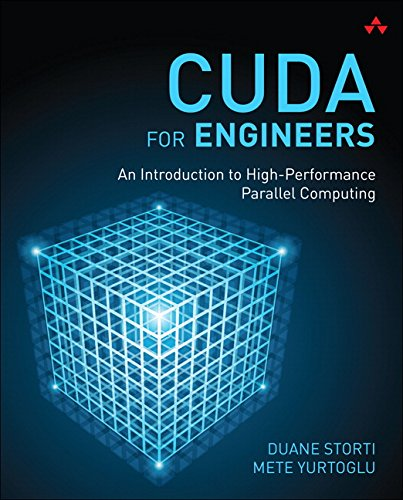

In [33]:
image2

In [34]:
task_prompt = '<OCR>'
run_example(task_prompt)

{'<OCR>': '-\n'}

In [35]:
task_prompt = '<OCR_WITH_REGION>'
results = run_example(task_prompt)
print(results)
# ocr results format
# {'OCR_WITH_REGION': {'quad_boxes': [[x1, y1, x2, y2, x3, y3, x4, y4], ...], 'labels': ['text1', ...]}}

{'<OCR_WITH_REGION>': {'quad_boxes': [[207.10400390625, 187.64801025390625, 219.9040069580078, 187.64801025390625, 219.9040069580078, 194.81600952148438, 207.10400390625, 194.81600952148438]], 'labels': ['</s>٠٠']}}


In [36]:
def draw_ocr_bboxes(image, prediction, scale=1):
    draw = ImageDraw.Draw(image2)
    bboxes, labels = prediction['quad_boxes'], prediction['labels']
    for box, label in zip(bboxes, labels):
        color = random.choice(colormap)
        new_box = (np.array(box) * scale).tolist()
        draw.polygon(new_box, width=3, outline=color)
        draw.text((new_box[0]+8, new_box[1]+2),
                    "{}".format(label),
                    align="right",

                    fill=color)

    display(image2)

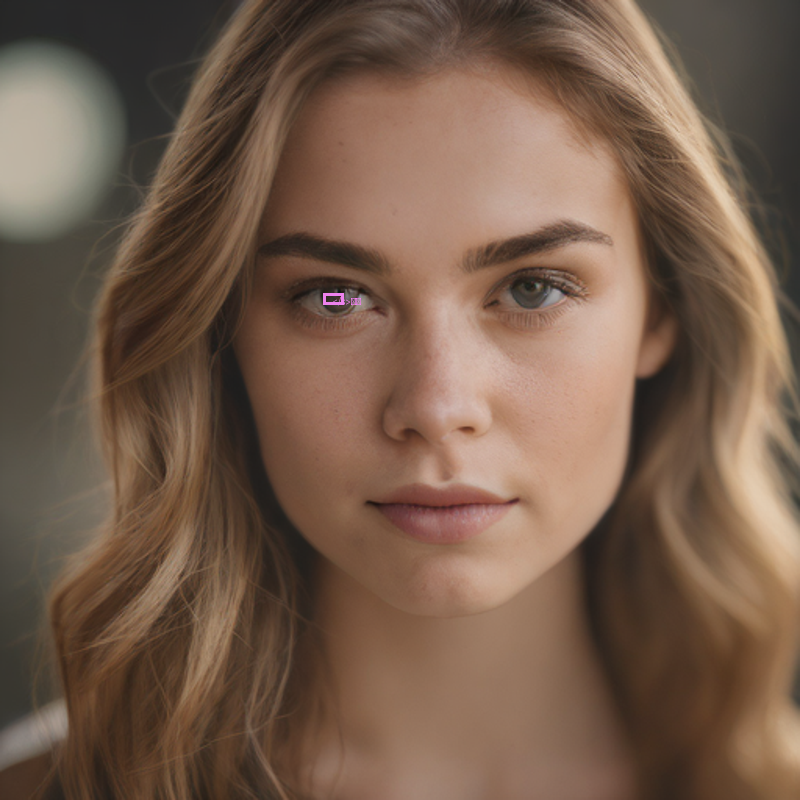

In [37]:
output_image = copy.deepcopy(image2)
w, h = output_image.size
scale = 800 / max(w, h)
new_output_image = output_image.resize((int(w * scale), int(h * scale)))
draw_ocr_bboxes(new_output_image, results['<OCR_WITH_REGION>'], scale=scale)

## Cascaded tasks

### Caption + Phrase Grounding

results format:

{
 '\<CAPTION': pure_text,
{'\<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['', '', ...]}}
}

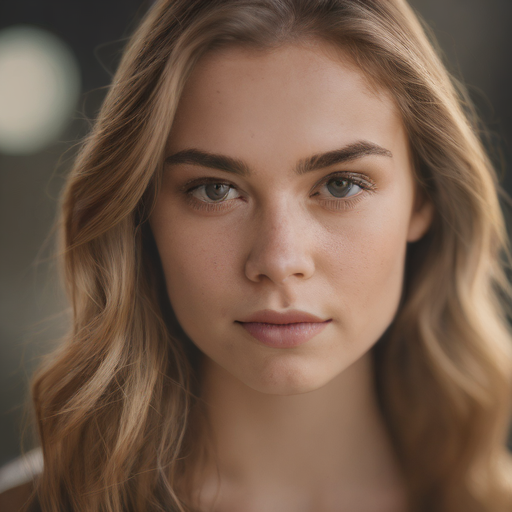

In [38]:
image

In [39]:
task_prompt = '<CAPTION>'
results = run_example(task_prompt)
text_input = results[task_prompt]
task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
results = run_example(task_prompt, text_input)
results['<CAPTION>'] = text_input

In [40]:
results

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[24.832000732421875,
    1.7920000553131104,
    509.18402099609375,
    508.6720275878906],
   [24.832000732421875,
    1.28000009059906,
    509.6960144042969,
    509.6960144042969],
   [180.48001098632812,
    169.72801208496094,
    378.1120300292969,
    208.1280059814453],
   [309.5040283203125,
    170.24000549316406,
    377.0880126953125,
    202.49600219726562],
   [183.04000854492188,
    177.4080047607422,
    247.55201721191406,
    207.10400390625]],
  'labels': ['A woman', 'hair', 'eyes', 'eyes', 'eyes']},
 '<CAPTION>': 'A woman with long blonde hair and blue eyes.'}

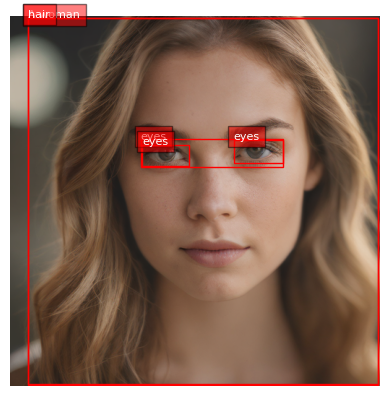

In [41]:
plot_bbox(image, results['<CAPTION_TO_PHRASE_GROUNDING>'])

### Detailed Caption + Phrase Grounding

results format:

{
 '\<DETAILED_CAPTION': pure_text,
{'\<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['', '', ...]}}
}

In [42]:
task_prompt = '<DETAILED_CAPTION>'
results = run_example(task_prompt)
text_input = results[task_prompt]
task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
results = run_example(task_prompt, text_input)
results['<DETAILED_CAPTION>'] = text_input

In [43]:
results

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[4.86400032043457,
    2.30400013923645,
    509.18402099609375,
    509.6960144042969],
   [177.92001342773438,
    167.6800079345703,
    380.6720275878906,
    212.22401428222656],
   [307.968017578125,
    169.21600341796875,
    379.1360168457031,
    205.05601501464844],
   [180.99200439453125,
    175.87200927734375,
    249.60000610351562,
    210.68800354003906],
   [308.4800109863281, 169.72801208496094, 378.6240234375, 204.54400634765625],
   [177.92001342773438,
    167.6800079345703,
    381.18402099609375,
    212.22401428222656],
   [178.9440155029297,
    168.19200134277344,
    380.1600036621094,
    211.71200561523438],
   [308.4800109863281,
    169.72801208496094,
    379.1360168457031,
    204.54400634765625],
   [180.99200439453125,
    175.87200927734375,
    250.1120147705078,
    210.68800354003906],
   [147.20001220703125,
    47.36000061035156,
    419.5840148925781,
    397.0560302734375]],
  'labels': ['a woman'

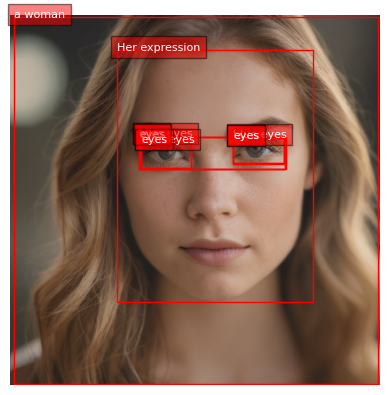

In [44]:
plot_bbox(image, results['<CAPTION_TO_PHRASE_GROUNDING>'])

### More Detailed Caption + Phrase Grounding

results format:

{
 '\<MORE_DETAILED_CAPTION': pure_text,
{'\<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['', '', ...]}}
}

In [45]:
task_prompt = '<MORE_DETAILED_CAPTION>'
results = run_example(task_prompt)
text_input = results[task_prompt]
task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
results = run_example(task_prompt, text_input)
results['<MORE_DETAILED_CAPTION>'] = text_input

In [46]:
results

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[148.22401428222656,
    44.80000305175781,
    416.0000305175781,
    396.54400634765625],
   [176.38400268554688,
    167.1680145263672,
    380.6720275878906,
    211.71200561523438],
   [308.4800109863281,
    169.21600341796875,
    377.6000061035156,
    203.52000427246094],
   [162.04800415039062,
    137.4720001220703,
    395.0080261230469,
    176.89601135253906],
   [294.1440124511719,
    137.9840087890625,
    393.9840087890625,
    174.3360137939453],
   [163.58401489257812,
    146.17601013183594,
    251.64801025390625,
    177.4080047607422],
   [1.28000009059906,
    23.296001434326172,
    83.71200561523438,
    156.92800903320312]],
  'labels': ['face',
   'Her eyes',
   'eyes',
   'eyebrows',
   'eyebrows',
   'eyebrows',
   'The lighting']},
 '<MORE_DETAILED_CAPTION>': "The image is a close-up portrait of a young woman's face. She has blonde hair that is styled in loose waves and falls over her shoulders. Her eyes are 

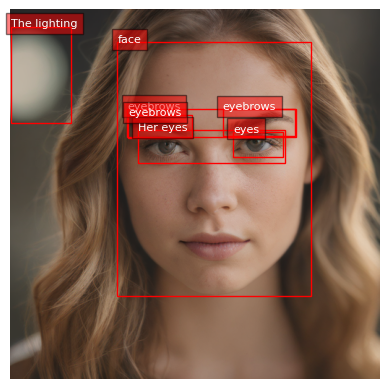

In [47]:
plot_bbox(image, results['<CAPTION_TO_PHRASE_GROUNDING>'])

# Florence-2 Captioning + Euristica Detection AI vs Real per Prompt Engineering

## Prompt per caption dettagliato

In [54]:
task_prompt = '<MORE_DETAILED_CAPTION>'
results = run_example(task_prompt)
text_input = results[task_prompt]
# Salva il caption generato
results['<MORE_DETAILED_CAPTION>'] = text_input
print("\033[1mCaption generato:\033[0m", text_input)

Caption generato: The image is a close-up portrait of a young woman's face. She has blonde hair that is styled in loose waves and falls over her shoulders. Her eyes are a piercing blue and her eyebrows are perfectly groomed. She is looking directly at the camera with a serious expression. The background is blurred, so the focus is on her face. The lighting is soft and natural, highlighting her features. The overall mood of the image is calm and serene.


##Prompt per detection AI vs Real

In [55]:
task_prompt_detection = "Based on the following detailed caption, is the described image AI-generated or a real photo? Answer in one word: 'AI' or 'Real'.\n"
detection_results = run_example(task_prompt_detection, text_input)
detection_decision = detection_results[task_prompt_detection] if isinstance(detection_results, dict) else detection_results
print("\033[1mAI Detection (euristica):\033[0m", detection_decision)


AI Detection (euristica): Described image AI-generated<loc_2><loc_46><loc_161><loc_305>The image<loc_7><loc_4><loc_993><loc_993>face<loc_287><loc_86><loc_813><loc_774>Her eyes<loc_343><loc_325><loc_744><loc_416>eyebrows<loc_315><loc_268><loc_772><loc_347><loc_573><loc_269><loc_770><loc_341><loc_318><loc_285><loc_491><loc_347>The lighting<loc_2><loc_46><loc_162><loc_305>


##Esecuzione e stampa caption

In [57]:
if 'AI' in detection_decision.upper():
    # Prompt grounding mirato per individuare aree sospette
    grounding_prompt = "<CAPTION_TO_PHRASE_GROUNDING>"
    grounding_results = run_example(grounding_prompt, text_input)

    print("\033[1mPhrase Grounding motivi sospetti:\033[0m", grounding_results)

    # Visualizza bbox se presenti
    if 'bboxes' in grounding_results and grounding_results['bboxes']:
        plot_bbox(image, grounding_results)
    else:
        print("⚠️ Nessun bbox restituito per grounding.")
else:
    print("✅ L'immagine è stata considerata reale, quindi il grounding non viene eseguito.")

Phrase Grounding motivi sospetti: {'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[148.22401428222656, 44.80000305175781, 416.0000305175781, 396.54400634765625], [176.38400268554688, 167.1680145263672, 380.6720275878906, 211.71200561523438], [308.4800109863281, 169.21600341796875, 377.6000061035156, 203.52000427246094], [162.04800415039062, 137.4720001220703, 395.0080261230469, 176.89601135253906], [294.1440124511719, 137.9840087890625, 393.9840087890625, 174.3360137939453], [163.58401489257812, 146.17601013183594, 251.64801025390625, 177.4080047607422], [1.28000009059906, 23.296001434326172, 83.71200561523438, 156.92800903320312]], 'labels': ['face', 'Her eyes', 'eyes', 'eyebrows', 'eyebrows', 'eyebrows', 'The lighting']}}
⚠️ Nessun bbox restituito per grounding.


##Esecuzione e stampa detection